# Strain mapping with all calibrations

___

## 1A: Prepare Data - Preprocess

Preprocessing will vary a great deal based on individual datasets.  Consequently, this notebook is intentionally left fairly minimal.  Nearly all steps here are optional, and any preprocessing you choose to do on your data will require adapting the suggested functions for your use-case.  

The only step that is required here is generating a virtual image, as it will be used for display elsewhere in the strain mapping notebooks.

Other optional steps include compressing data to a more manageable size by binning or cropping, and  cleaning the data for higher accuracy measurements by performing a background subtraction.  For information about file format conversion, see py4DSTEM/notebooks/basic_demos/filehandling_non-nativefiles.ipynb.

___

- Inputs:
  - raw 4D-STEM scan
- Outputs:
  - reference image
  - processed 4D-STEM scan

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import py4DSTEM

### Load data

In [2]:
# Examine contents of sampledata.h5

fp = "/media/AuxDriveB/Data/20190904_StrainMappingExample_with_Calibrations/sampledata.h5"
browser = py4DSTEM.file.io.FileBrowser(fp)
browser.show_dataobjects()

 Index                  Name                        Type        
   0    calibration_4DSTEM_scan             DataCube            
   1    experimental_4DSTEM_scan            DataCube            
   2    vacuum_4DSTEM_scan                  DataCube            
   3    CBED_shadow_image                   RealSlice           
   4    HAADF_image                         RealSlice           


In [3]:
# Load the experimental data

dc = browser.get_dataobject('experimental_4DSTEM_scan')
browser.close()

### Generate a virtual image

Choose a virtual detector, and use it to generate a virtual image.  This image is used for visualization later in the workflow.

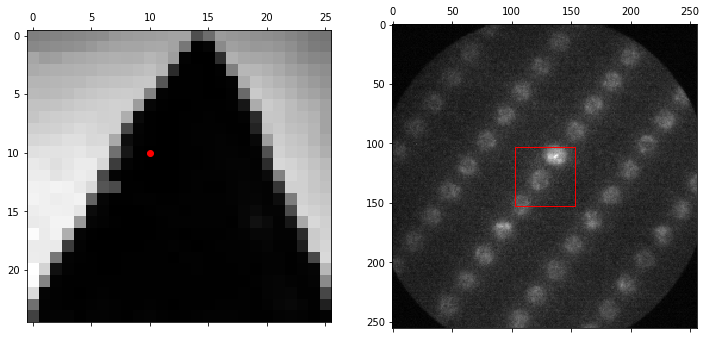

In [4]:
# Display an initial image and diffraction pattern
# For an initial image, use a square detector in the middle of the diffraction plane

detector_width = 50
rx,ry = 10,10           # Display a diffraction pattern from this scan position 

qx0,qxf = int((dc.Q_Nx-detector_width)/2),int((dc.Q_Nx+detector_width)/2)
qy0,qyf = int((dc.Q_Ny-detector_width)/2),int((dc.Q_Ny+detector_width)/2)
im = dc.get_virtual_image_rect_integrate(slice(qx0,qxf),slice(qy0,qyf))[0]

fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].matshow(im)
axs[0].scatter(ry,rx,color='r')
axs[1].matshow(dc.data[rx,ry,:,:])
rect = Rectangle((qy0,qx0),qyf-qy0,qxf-qx0,fill=False,color='r')
axs[1].add_patch(rect)
plt.show()

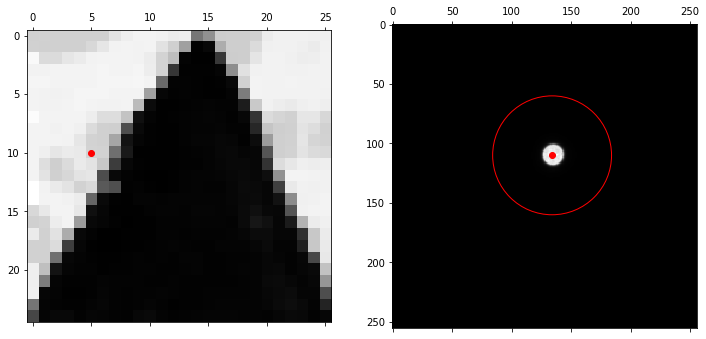

In [5]:
# Make a bright field image by centering a circular virtual detector about the unscattered beam

detector_radius = 50
qx,qy = 110,134         # Select center of virtual detector
rx,ry = 10,5           # Display a diffraction pattern from this scan position 

qx0,qxf = int(qx-detector_radius),int(qx+detector_radius)
qy0,qyf = int(qy-detector_radius),int(qy+detector_radius)
BF = dc.get_virtual_image_circ_integrate(slice(qx0,qxf),slice(qy0,qyf))[0]

fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].matshow(BF)
axs[0].scatter(ry,rx,color='r')
axs[1].matshow(dc.data[rx,ry,:,:])
circ = Circle((qy,qx),detector_radius,fill=False,color='r')
axs[1].scatter(qy,qx,color='r')
axs[1].add_patch(circ)
plt.show()

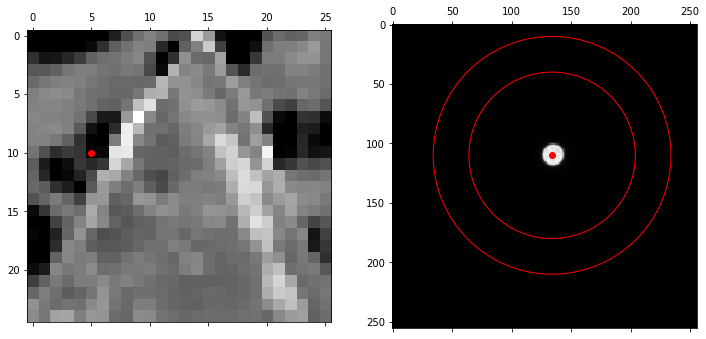

In [6]:
# Make an annular dark-field image by centering an annular virtual detector about the unscattered beam

detector_inner_radius = 70
detector_outer_radius = 100
qx,qy = 110,134             # Select center of virtual detector
rx,ry = 10,5                # Display a diffraction pattern from this scan position 

qx0,qxf = int(qx-detector_outer_radius),int(qx+detector_outer_radius)
qy0,qyf = int(qy-detector_outer_radius),int(qy+detector_outer_radius)
ADF = dc.get_virtual_image_annular_integrate(slice(qx0,qxf),slice(qy0,qyf),detector_outer_radius/detector_inner_radius)[0]

fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].matshow(ADF)
axs[0].scatter(ry,rx,color='r')
axs[1].matshow(dc.data[rx,ry,:,:])
circ1 = Circle((qy,qx),detector_inner_radius,fill=False,color='r')
circ2 = Circle((qy,qx),detector_outer_radius,fill=False,color='r')
axs[1].scatter(qy,qx,color='r')
axs[1].add_patch(circ1)
axs[1].add_patch(circ2)
plt.show()

In [7]:
# Choose an image and save it.
# All data generated in this workflow will be added one-by-one to a single HDF5 file.

virtual_image = py4DSTEM.file.datastructure.RealSlice(data=ADF)   # Set data=(an image generated above)
virtual_image.name = 'virtual_image'

fp_processing = "/media/AuxDriveB/Data/20190904_StrainMappingExample_with_Calibrations/processing_sampledata.h5"
py4DSTEM.file.io.save(virtual_image,fp_processing)

Creating file /media/AuxDriveB/Data/20190904_StrainMappingExample_with_Calibrations/processing_sampledata.h5...
Done.


### Bin and crop data

Note that if the experimental data is binned, the vacuum probe and calibration data need to be binned in the same way!

In [36]:
# Functions for cropping data

# dc.crop_data_real(Rx_min,Rx_max,Ry_min,Ry_max)            # in real space
# dc.crop_data_diffraction(Qx_min,Qx_max,Qy_min,Qy_max)     # in reciprocal space

In [37]:
# Functions for binning data

# dc.bin_data_real(bin_factor)           # in real space
# dc.bin_data_diffraction(bin_factor)    # in diffraction space

### Background subtract

Get a dark reference, and subtract it from all diffraction patterns.

In [ ]:
# from py4DSTEM.process.preprocess import get_darkreference
# from py4DSTEM.process.preprocess import get_bksbtr_DP

In [ ]:
# Calculate the dark reference

# darkref = get_darkreference(datacube=dc, N_frames=50,      # number of random DPs to average
#                                          width_x=30,       # width of strip on side of DP to average streaks over
#                                          width_y=30,          
#                                          side_x='end',     # use a strip on the array left/right (top/bottom)
#                                          side_y='end')

In [ ]:
# Perform background subtraction

# for Rx in range(dc.R_Nx):
#     for Ry in range(dc.R_Ny):
#         dc.data[Rx,Ry,:,:] = get_bksbtr_DP(dc, darkref, Rx, Ry)

### Save processed datacube

In [ ]:
# savepath = "/media/AuxDriveB/Data/20190904_StrainMappingExample_with_Calibrations/processing_sampledata.h5"
# py4DSTEM.file.io.save(dc,savepath)